# Permutation-invariant model

In [1]:
import numpy as np
from models import GPT2Model

#############################################
N = 30000
qcd_run_id = "6dbdefc3636949bba09fa965acd24a73"
tops_run_id = "ebb880aee8c2447a972e5b3f570704a5"
#############################################

path = "/home/df630/SyntheticJets/experiments/results/comet/synthetic-jets"

qcd_gpt2 = GPT2Model.load_from_checkpoint(f"{path}/{qcd_run_id}/checkpoints/best.ckpt")
tops_gpt2 = GPT2Model.load_from_checkpoint(f"{path}/{tops_run_id}/checkpoints/best.ckpt")



INFO: vocab_size: 300, start_token_id: 300
INFO: vocab_size: 300, start_token_id: 300


## Jet generation

In [2]:
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as L

qcd_gpt2.predict_output = 'jet_binned'

prompts = torch.full((N, 1), qcd_gpt2.start_token, dtype=torch.long, device=qcd_gpt2.device)
prompt_dataloadeer = DataLoader(prompts, batch_size=1024, shuffle=False)

generator = L.Trainer(accelerator="gpu", devices=1)
jets_binned = generator.predict(qcd_gpt2, dataloaders=prompt_dataloadeer)
qcd_jets_binned = torch.cat(jets_binned, dim=0)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/df630/.conda/envs/markov_bridges/lib/python3.10/site-packages/pytorch_lightning-2.5.0.post0-py3.10.egg/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [3]:
tops_gpt2.predict_output = 'jet_binned'

prompts = torch.full((N, 1), tops_gpt2.start_token, dtype=torch.long, device=tops_gpt2.device)
prompt_dataloadeer = DataLoader(prompts, batch_size=1024, shuffle=False)

generator = L.Trainer(accelerator="gpu", devices=1)
jets_binned = generator.predict(tops_gpt2, dataloaders=prompt_dataloadeer)
tops_jets_binned = torch.cat(jets_binned, dim=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [4]:
from synthetic_data import SyntheticJets
from utils import kin_plots, ordered_z_plots

qcd = SyntheticJets(shape_param=qcd_gpt2.shape, 
                    scale_param=qcd_gpt2.scale, 
                    bins_z= qcd_gpt2.bins_z,
                    bins_phi=qcd_gpt2.bins_phi,
                    z_order=True,
                    tokenize=True,
                    )

toy_qcd  = qcd.sample(N=N)
toy_qcd = qcd.token_to_bins(toy_qcd)

tops = SyntheticJets(shape_param=tops_gpt2.shape, 
                    scale_param=tops_gpt2.scale, 
                    bins_z= tops_gpt2.bins_z,
                    bins_phi=tops_gpt2.bins_phi,
                    z_order=True,
                    tokenize=True,
                    )

toy_tops  = tops.sample(N=N)
toy_tops = tops.token_to_bins(toy_tops)

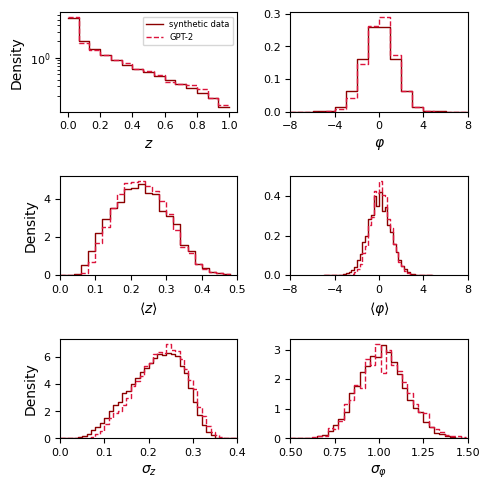

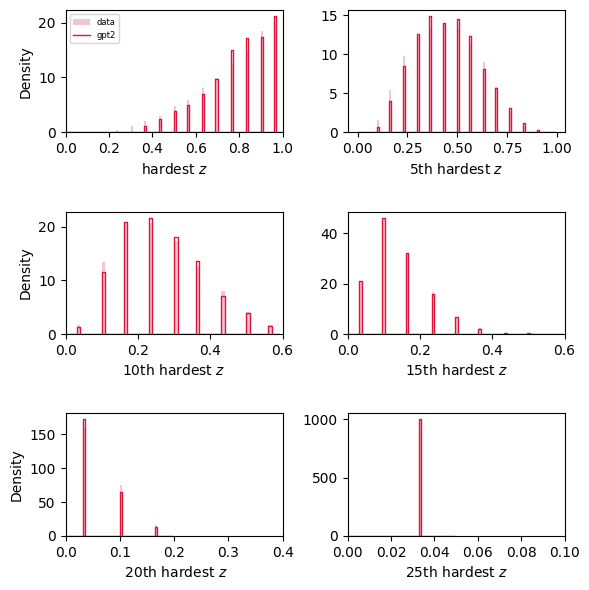

In [12]:
kin_plots(toy_qcd, qcd_jets_binned, "qcd_kin.png")
ordered_z_plots(toy_qcd, qcd_jets_binned)

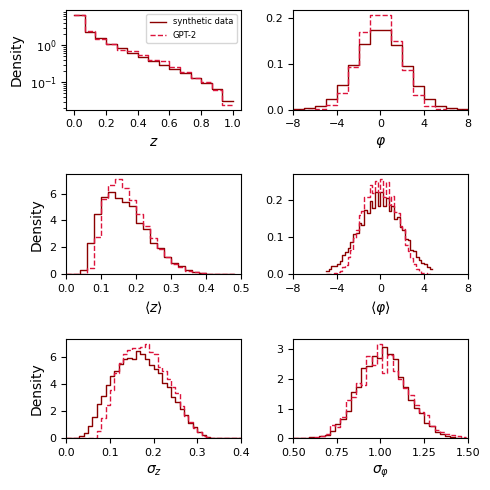

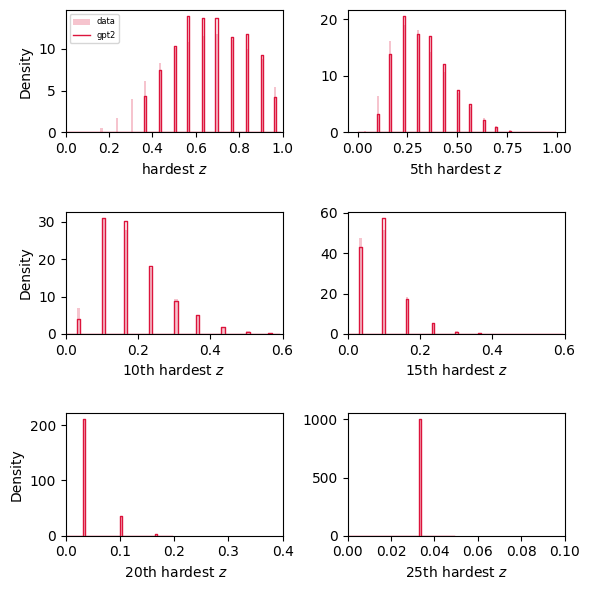

In [11]:
kin_plots(toy_tops, tops_jets_binned, "tops_kin.png")
ordered_z_plots(toy_tops, tops_jets_binned)

## log-likelihood ratio

In [13]:
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as L

qcd_gpt2.predict_output = 'jet_sequence'

prompts = torch.full((N, 1), qcd_gpt2.start_token, dtype=torch.long, device=qcd_gpt2.device)
prompt_dataloadeer = DataLoader(prompts, batch_size=1024, shuffle=False)

generator = L.Trainer(accelerator="gpu", devices=1)
seq = generator.predict(qcd_gpt2, dataloaders=prompt_dataloadeer)
qcd_seq = torch.cat(seq, dim=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/df630/.conda/envs/markov_bridges/lib/python3.10/site-packages/pytorch_lightning-2.5.0.post0-py3.10.egg/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [14]:
tops_gpt2.predict_output = 'jet_sequence'

prompts = torch.full((N, 1), tops_gpt2.start_token, dtype=torch.long, device=tops_gpt2.device)
prompt_dataloadeer = DataLoader(prompts, batch_size=1024, shuffle=False)

generator = L.Trainer(accelerator="gpu", devices=1)
seq = generator.predict(tops_gpt2, dataloaders=prompt_dataloadeer)
tops_seq = torch.cat(seq, dim=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [16]:
def compute_log_likelihood(model, token_sequences, batch_size=256, device="cuda"):
    """
    Compute log-probabilities of tokenized sequences using GPT-2.

    Args:
        model: Trained GPT2Model (LightningModule).
        token_sequences: torch.Tensor of shape (N, D), dtype=torch.long
        batch_size: number of sequences per batch
        device: 'cuda' or 'cpu'

    Returns:
        log_probs: torch.Tensor of shape (N,) — log-probabilities per sequence
    """
    from torch.utils.data import DataLoader, TensorDataset
    import torch.nn.functional as F

    model.eval()
    model.to(device)

    # Add start token
    N, D = token_sequences.shape
    start = torch.full((N, 1), model.start_token, dtype=torch.long, device=device)
    input_ids = torch.cat([start, token_sequences.to(device)], dim=1)  # (N, D+1)

    # Dataset and loader
    dataset = TensorDataset(input_ids)
    loader = DataLoader(dataset, batch_size=batch_size)

    log_probs = []

    with torch.no_grad():
        for (batch,) in loader:
            outputs = model.model(batch, labels=batch)
            # outputs.loss is averaged over all tokens
            # logits: (B, D+1, vocab_size), labels: (B, D+1)
            logits = outputs.logits[:, :-1]         # drop last token prediction
            labels = batch[:, 1:]                   # predict from start to end
            log_probs_batch = -F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                labels.reshape(-1),
                reduction='none'
            ).reshape(batch.size(0), -1).sum(dim=-1)  # sum log-probs per sequence
            log_probs.append(log_probs_batch.cpu())

    return torch.cat(log_probs, dim=0)  # shape (N,)


In [17]:
log_p_qcd = compute_log_likelihood(qcd_gpt2, qcd_seq)
log_p_tops = compute_log_likelihood(tops_gpt2, tops_seq)


In [19]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_likelihood_ratio_roc(qcd_model, tops_model, qcd_seq, tops_seq, batch_size=256, device="cuda"):

    print("Computing QCD likelihoods...")
    log_p_qcd_qcd = compute_log_likelihood(qcd_model, qcd_seq, batch_size=batch_size, device=device)
    print("Computing Tops likelihoods...")
    log_p_tops_tops = compute_log_likelihood(tops_model, tops_seq, batch_size=batch_size, device=device)

    print("Computing cross likelihoods...")
    log_p_tops_qcd = compute_log_likelihood(tops_model, qcd_seq, batch_size=batch_size, device=device)
    log_p_qcd_tops = compute_log_likelihood(qcd_model, tops_seq, batch_size=batch_size, device=device)

    # log likelihood ratios
    llr_qcd = log_p_tops_qcd - log_p_qcd_qcd   # tops vs qcd on QCD samples
    llr_tops = log_p_tops_tops - log_p_qcd_tops  # tops vs qcd on Tops samples

    # Labels: 0 = QCD, 1 = Tops
    llrs = torch.cat([llr_qcd, llr_tops]).numpy()
    labels = np.concatenate([np.zeros_like(llr_qcd), np.ones_like(llr_tops)])

    # ROC
    fpr, tpr, thresholds = roc_curve(labels, llrs)
    roc_auc = auc(fpr, tpr)

    # # Plot
    # plt.figure(figsize=(6, 5))
    # plt.plot(fpr, tpr, label=f"LLR ROC (AUC = {roc_auc:.4f})")
    # plt.plot([0, 1], [0, 1], "k--", lw=1)
    # plt.xlabel("False Positive Rate (QCD mislabeled)")
    # plt.ylabel("True Positive Rate (Top correctly labeled)")
    # plt.title("ROC Curve: Likelihood Ratio Test")
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

    plt.figure(figsize=(4, 3))
    plt.plot(tpr, 1 / fpr, label=f"AUC NP = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("Toy tops efficiency")
    plt.ylabel("Toy QCD rejection")
    plt.title("ROC curve")
    plt.legend()
    plt.yscale("log")


    return fpr, tpr, thresholds, llrs, labels


Computing QCD likelihoods...
Computing Tops likelihoods...
Computing cross likelihoods...


/tmp/ipykernel_1939588/1301174411.py:42: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1 / fpr, label=f"AUC NP = {roc_auc:.2f}")


(array([0.    , 0.    , 0.    , ..., 0.9816, 0.9816, 1.    ]),
 array([0.00000000e+00, 3.33333333e-05, 3.29666667e-02, ...,
        9.99966667e-01, 1.00000000e+00, 1.00000000e+00]),
 array([        inf,  28.40744  ,   5.3429565, ...,  -5.245453 ,
         -5.245682 , -12.674156 ], dtype=float32),
 array([-0.5983391, -1.1582146, -1.2256584, ...,  1.2034836,  8.820656 ,
         0.0601387], dtype=float32),
 array([0., 0., 0., ..., 1., 1., 1.], dtype=float32))

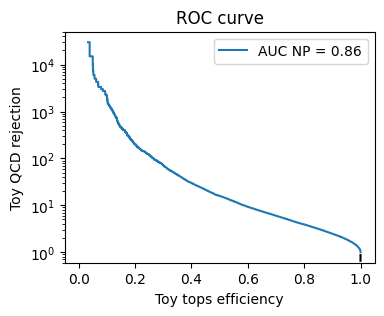

In [20]:
plot_likelihood_ratio_roc(
    qcd_model=qcd_gpt2,
    tops_model=tops_gpt2,
    qcd_seq=qcd_seq,     # shape (N, D)
    tops_seq=tops_seq,   # shape (M, D)
    batch_size=256,
    device="cuda"
)

In [ ]:
LLR_qcd = LLR(toy_qcd, signal=tops, background=qcd)
LLR_tops = LLR(toy_tops, signal=tops, background=qcd)

# np.save('toy_bkg_data_LLR.npy', LLR_qcd)
# np.save('toy_sig_data_LLR.npy', LLR_tops)

ROC(LLR_qcd, LLR_tops)



plt.figure(figsize=(3,1.))
sns.histplot(LLR_qcd, bins=np.arange(-4,10,0.05), color='crimson', alpha=0.2, lw=0.8, label='S', element='step', stat='density')
sns.histplot(LLR_tops, bins=np.arange(-4,10,0.05), color='blue', alpha=0.2, lw=0.8, label='B', element='step', stat='density')
plt.xlabel(r'log-likelihood ratio')
plt.xlim(-4, 5)
plt.ylabel('Density')
# plt.yscale('log')
plt.legend(loc='upper right', fontsize=8)
# plt.savefig('toy_LLR.png', dpi=300, bbox_inches='tight')
plt.show()